#**Extract rate BCE**

In [ ]:
!pip install nltk
!pip install PyDictionary

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=92eab0656460023b133379e32eabc44d52b5090f992a3e28523dcdd791717349
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for goslate: filename=goslate-1.5.4-py3-none-any.whl size=11580 sha256=8f0f492ba981b39b1917f32b188590654d42b205b967cf8a29e4a9d33e5c862b
  Stored in directory: /root/.cache/pip/wheels/b5/30/e9/63b6de83667be2977ee793a146a2c80f8e588d5c0203b39dc9
  Created wheel for futures: filename=futures-3.0.5-py3-none-any.whl size=14068 sha256=61ba69def61b56c87ab0d76d782ebdbfb2b71296c695b4dc6609a79a465b1c5e
  Stored in directory: /root/.cache/pip/wheels/ef/af/93/48739d464ba97d4cdc77c627d282f9794c8d276e42aaa92160
Successfully built bs4 goslate futures


#*Trying with synonyms*

In [ ]:
#NLP
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

increase_synonyms = get_synonyms('increase') + get_synonyms('raise')
decrease_synonyms = get_synonyms('decrease')
stagnation_synonyms = get_synonyms('stagnation')

print(f"Synonyms for 'increase': {increase_synonyms}")
print(f"Synonyms for 'decrease': {decrease_synonyms}")
print(f"Synonyms for 'stagnation': {stagnation_synonyms}")


Synonyms for 'increase': ['increase', 'growth', 'addition', 'step-up', 'increment', 'gain', 'prove', 'rise', 'upgrade', 'wage_hike', 'arouse', 'erect', 'elevate', 'set_up', 'acclivity', 'salary_increase', 'farm', 'conjure_up', 'evoke', 'call_forth', 'advance', 'wage_increase', 'put_up', 'raise', 'enhance', 'heave', 'rear', 'kick_upstairs', 'invoke', 'nurture', 'call_down', 'kindle', 'heighten', 'ascent', 'parent', 'enkindle', 'elicit', 'fire', 'upraise', 'grow', 'stir', 'put_forward', 'recruit', 'hike', 'levy', 'get_up', 'produce', 'resurrect', 'leaven', 'bring_up', 'lift', 'conjure', 'promote', 'climb', 'provoke']
Synonyms for 'decrease': ['reduction', 'decrease', 'lessening', 'lessen', 'drop-off', 'decrement', 'minify', 'diminution', 'step-down', 'diminish', 'fall']
Synonyms for 'stagnation': ['stagnation', 'doldrums', 'stagnancy']


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from PyDictionary import PyDictionary
import pandas as pd
import re

def extract_rate_decisions(statement):

    increase_pattern = r"(" + "|".join(increase_synonyms) + r")[d]? by (\d*\.?\d+)%?"
    decrease_pattern = r"(" + "|".join(decrease_synonyms) + r")[d]? by (\d*\.?\d+)%?"
    stagnation_pattern = r"(" + "|".join(stagnation_synonyms) + r")"

    patterns = {
        "increase": increase_pattern,
        "decrease": decrease_pattern,
        "stagnation": stagnation_pattern
    }

    for decision, pattern in patterns.items():
        match = re.search(pattern, statement, re.IGNORECASE)
        if match:
            if decision in ["increase", "decrease"]:
                # Extract the percentage point (the idea is then to convert the sentimental analysis score in %age)
                point_change = match.group(2)
                return f"{decision.capitalize()} by {point_change}%"
            else:
                return "Rate remains unchanged"

    # 'No clear decision' if no decision is found
    return "No clear decision"

data = pd.read_csv('/content/sentiment_score_bert_ecb_statement.csv')
decisions_df = pd.DataFrame(columns=["ECB", "Decision", "Date", "Negative_Score", "Neutral_Score", "Positive_Score"])

for index, row in data.iterrows():
    decision = extract_rate_decisions(row['ecb_statement'])
    decisions_df.loc[index] = {
        "ECB": "YES", #to merge with FED then
        "Decision": decision,
        "Date": row['date'],
        "Negative_Score": row['negative_score'],
        "Neutral_Score": row['neutral_score'],
        "Positive_Score": row['positive_score']
    }


#decisions_df.to_csv('decisionsand%ageBCE.csv', index=False)
#didn't work well, trying another method


#*Trying with the csv from the ECB website*

In [ ]:
import pandas as pd

# First, datas
ecb_historical_data = pd.read_csv('/content/ECBhistoricaldata.csv', delimiter=';')
sentiment_score_data = pd.read_csv('/content/sentiment_score_bert_ecb_statement.csv')

# Date columns to datetime
ecb_historical_data['date'] = pd.to_datetime(ecb_historical_data['date'])
sentiment_score_data['date'] = pd.to_datetime(sentiment_score_data['date'])

# Merging datas
merged_data = pd.merge(ecb_historical_data, sentiment_score_data, left_on='date', right_on='date')
print(merged_data.head())
# Did'nt work well (data scale, not a lot of datas) so let's try something else

Empty DataFrame
Columns: [date, Value, ecb_statement, negative_score, neutral_score, positive_score, sentiment_score]
Index: []


#*Trying Extracting from FRED*

In [ ]:
pip install pandas_datareader

In [ ]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime

# Step 1: Fetching the Euro Area Inflation Rate from FRED
# We are using the FRED ticker 'CP0000EZ19M086NEST' for this purpose
start = datetime(2012, 1, 1)
end = datetime(2023, 1, 1)
df_inflation = pdr.get_data_fred('CP0000EZ19M086NEST', start, end)
df_inflation.reset_index(inplace=True)
df_inflation.rename(columns={'DATE': 'Date', 'CP0000EZ19M086NEST': 'Inflation_Rate'}, inplace=True)
df_inflation['Date'] = pd.to_datetime(df_inflation['Date'])

# Step 2: Fetching the ECB's main refinancing operations fixed rate
df_ECB = pdr.get_data_fred('ECBMRRFR', start, end)
df_ECB.reset_index(inplace=True)
df_ECB.rename(columns={'DATE': 'Date', 'ECBMRRFR': 'Value'}, inplace=True)
df_ECB['Date'] = pd.to_datetime(df_ECB['Date'])

# Checking the date format in the ECB rate data
print("Date format in df_ECB:", df_ECB['Date'].dtypes)

# Step 3: Resampling the inflation data to daily frequency
# This fills any missing dates with the last available rate
df_inflation.set_index('Date', inplace=True)
df_inflation_daily = df_inflation.resample('D').ffill().reset_index()

# Step 4: Loading sentiment analysis data
sentiment_df = pd.read_csv('/content/sentiment_score_bert_ecb_statement.csv')
sentiment_df.rename(columns={'date': 'Date'}, inplace=True)
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'])

# Step 5: Merging the datasets on the 'Date' column
# This combines sentiment data with daily ECB rate and inflation rate data
mergedECB_df = pd.merge(sentiment_df, df_inflation_daily, how='inner', on='Date')
mergedECB_df = pd.merge(mergedECB_df, df_ECB, how='inner', on='Date')
mergedECB_df["ECB"] = "yes"  # Adding a column to indicate ECB data

# Step 6: Saving the merged DataFrame to a CSV file
#mergedECB_df.to_csv("merged_ECB_data_daily.csv", index=False)

# Step 7: Printing the first few rows to verify the merge
print(mergedECB_df.head())


Date format in df_ECB: datetime64[ns]
                                       ecb_statement  negative_score  \
0  Q&A on TARGET2-Securities\nLadies and gentleme...        0.000204   
1  Ladies and gentlemen, let me welcome you to ou...        0.000212   
2  Ladies and gentlemen, the Vice-President and I...        0.000194   
3  Ladies and gentlemen, the Vice-President and I...        0.000199   
4  Ladies and gentlemen, let me welcome you to ou...        0.000248   

   neutral_score  positive_score  \
0       0.000208        0.999588   
1       0.000335        0.999453   
2       0.000195        0.999611   
3       0.000202        0.999599   
4       0.000232        0.999520   

                                     sentiment_score       Date  \
0  {'positive_score': 0.9995879530906677, 'neutra... 2012-01-12   
1  {'positive_score': 0.9994531273841858, 'neutra... 2012-02-09   
2  {'positive_score': 0.9996110796928406, 'neutra... 2012-03-08   
3  {'positive_score': 0.9995989203453064, 'n

In [ ]:
# To compare, we are going to add a column with difference of rates + columns with "increase", "decrease", "stagnation".

# Calculate the day-to-day difference of rates, but this time we shift the difference by one period backward
# This means the rate difference for day 'n' will be based on the change from day 'n' to day 'n+1'
mergedECB_df['rate_difference'] = mergedECB_df['Value'].diff(periods=-1) * -1

# Define a function to categorize the rate changes based on the previous day's rate
def categorize_change(diff):
    if diff > 0:
        return 'increase'
    elif diff < 0:
        return 'decrease'
    else:
        return 'stagnation'

# Apply the function to the 'rate_difference' column to get the category of rate change
mergedECB_df['rate_change'] = mergedECB_df['rate_difference'].apply(categorize_change)

# The label for the last entry in the DataFrame will not be accurate since there's no "next day" to compare with
# So, we might want to set the last 'rate_change' to 'unknown' or NaN
mergedECB_df.at[mergedECB_df.index[-1], 'rate_change'] = None

# Now let's print the first few rows to see the new columns
print(mergedECB_df.head())

# Calculate the percentages for each category in 'rate_change'
rate_change_counts = mergedECB_df['rate_change'].value_counts(normalize=True) * 100

# Convert the series to a dictionary
rate_change_percentages = rate_change_counts.to_dict()
print(rate_change_percentages)

                                       ecb_statement  negative_score  \
0  Q&A on TARGET2-Securities\nLadies and gentleme...        0.000204   
1  Ladies and gentlemen, let me welcome you to ou...        0.000212   
2  Ladies and gentlemen, the Vice-President and I...        0.000194   
3  Ladies and gentlemen, the Vice-President and I...        0.000199   
4  Ladies and gentlemen, let me welcome you to ou...        0.000248   

   neutral_score  positive_score  \
0       0.000208        0.999588   
1       0.000335        0.999453   
2       0.000195        0.999611   
3       0.000202        0.999599   
4       0.000232        0.999520   

                                     sentiment_score       Date  \
0  {'positive_score': 0.9995879530906677, 'neutra... 2012-01-12   
1  {'positive_score': 0.9994531273841858, 'neutra... 2012-02-09   
2  {'positive_score': 0.9996110796928406, 'neutra... 2012-03-08   
3  {'positive_score': 0.9995989203453064, 'neutra... 2012-04-04   
4  {'positive_s

#**FED analysis**

We are going to follow the exact same process now and then compare the datasets.

In [ ]:
import pandas as pd
import pandas_datareader as pdr
from datetime import datetime

# Step 1: Fetching the Federal Funds Effective Rate (DFF) from the FRED database
# This rate is used as a benchmark for U.S. monetary policy
start = datetime(2012, 1, 1)
end = datetime(2023, 1, 1)
df_FED = pdr.get_data_fred('DFF', start, end)
df_FED.reset_index(inplace=True)
df_FED.rename(columns={'DATE': 'Date', 'DFF': 'Value'}, inplace=True)
df_FED['Date'] = pd.to_datetime(df_FED['Date'])

# Step 2: Fetching U.S. Inflation Rate
# We use the CPI for All Urban Consumers (CPIAUCSL) as a measure of inflation
df_inflation_US = pdr.get_data_fred('CPIAUCSL', start, end)
df_inflation_US.reset_index(inplace=True)
df_inflation_US.rename(columns={'DATE': 'Date', 'CPIAUCSL': 'Inflation_Rate'}, inplace=True)
df_inflation_US['Date'] = pd.to_datetime(df_inflation_US['Date'])

# Step 3: Resampling the inflation data to daily frequency
# This fills any missing dates with the last available rate
df_inflation_US.set_index('Date', inplace=True)
df_inflation_US_daily = df_inflation_US.resample('D').ffill().reset_index()

# Step 4: Loading sentiment analysis data
new_dataset_df = pd.read_csv('/content/sentiment_score_bert_communication.csv')
new_dataset_df.rename(columns={'date': 'Date'}, inplace=True)
new_dataset_df['Date'] = pd.to_datetime(new_dataset_df['Date'])
#print(new_dataset_df)

# Step 5: Merging the datasets on the 'Date' column
# This combines sentiment data with daily Fed rate and inflation rate data
mergedFED_df = pd.merge(new_dataset_df, df_FED, how='inner', on='Date')
mergedFED_df = pd.merge(mergedFED_df, df_inflation_US_daily, how='inner', on='Date')
mergedFED_df["FED"] = "yes"  # Adding a column to indicate FED data

# Step 6: Saving the merged DataFrame to a CSV file, using it for III
mergedFED_df.to_csv("FED_merged_with_inflation_daily.csv", index=False)

# Step 7: Printing the first few rows to verify the merge
print(mergedFED_df)


                                        ecb_statement  negative_score  \
0   Developments in Financial Markets and the Fede...        0.000309   
1   Developments in Financial Markets and the Fede...        0.000183   
2   Developments in Financial Markets and the Fede...        0.000273   
3   Developments in Financial Markets and the Fede...        0.000255   
4   Developments in Financial Markets and the Fede...        0.000949   
..                                                ...             ...   
77  Developments in Financial Markets and Open Mar...        0.007373   
78  Developments in Financial Markets and Open Mar...        0.995453   
79  Developments in Financial Markets and Open Mar...        0.000199   
80  Developments in Financial Markets and Open Mar...        0.000279   
81  Developments in Financial Markets and Open Mar...        0.689401   

    neutral_score  positive_score  \
0        0.000121        0.999570   
1        0.000112        0.999705   
2        0.0

In [ ]:
# Calculate the day-to-day difference of rates
mergedFED_df['rate_difference'] = mergedFED_df['Value'].diff(periods=-1) * -1

def categorize_change(diff):
    if diff > 0:
        return 'increase'
    elif diff < 0:
        return 'decrease'
    else:
        return 'stagnation'

# Apply the function to the 'rate_difference' column to get the category of rate change
mergedFED_df['rate_change'] = mergedFED_df['rate_difference'].apply(categorize_change)

# The label for the last entry in the DataFrame will not be accurate since there's no "next day" to compare with
mergedFED_df.at[mergedFED_df.index[-1], 'rate_change'] = None
print(mergedFED_df.head())

# Calculate the percentages for each category in 'rate_change'
rate_change_counts = mergedFED_df['rate_change'].value_counts(normalize=True) * 100

# Convert the series to a dictionary
rate_change_percentages = rate_change_counts.to_dict()
print(rate_change_percentages)


                                       ecb_statement  negative_score  \
0  Developments in Financial Markets and the Fede...        0.000309   
1  Developments in Financial Markets and the Fede...        0.000183   
2  Developments in Financial Markets and the Fede...        0.000273   
3  Developments in Financial Markets and the Fede...        0.000255   
4  Developments in Financial Markets and the Fede...        0.000949   

   neutral_score  positive_score  \
0       0.000121        0.999570   
1       0.000112        0.999705   
2       0.000970        0.998756   
3       0.000576        0.999169   
4       0.000453        0.998597   

                                     sentiment_score       Date  Value  \
0  {'positive_score': 0.9995697140693665, 'neutra... 2012-01-25   0.08   
1  {'positive_score': 0.9997047781944275, 'neutra... 2012-03-13   0.12   
2  {'positive_score': 0.9987564086914062, 'neutra... 2012-04-25   0.15   
3  {'positive_score': 0.999168872833252, 'neutral... 2

#**Let's work on the impacts**

#Graphic analysis

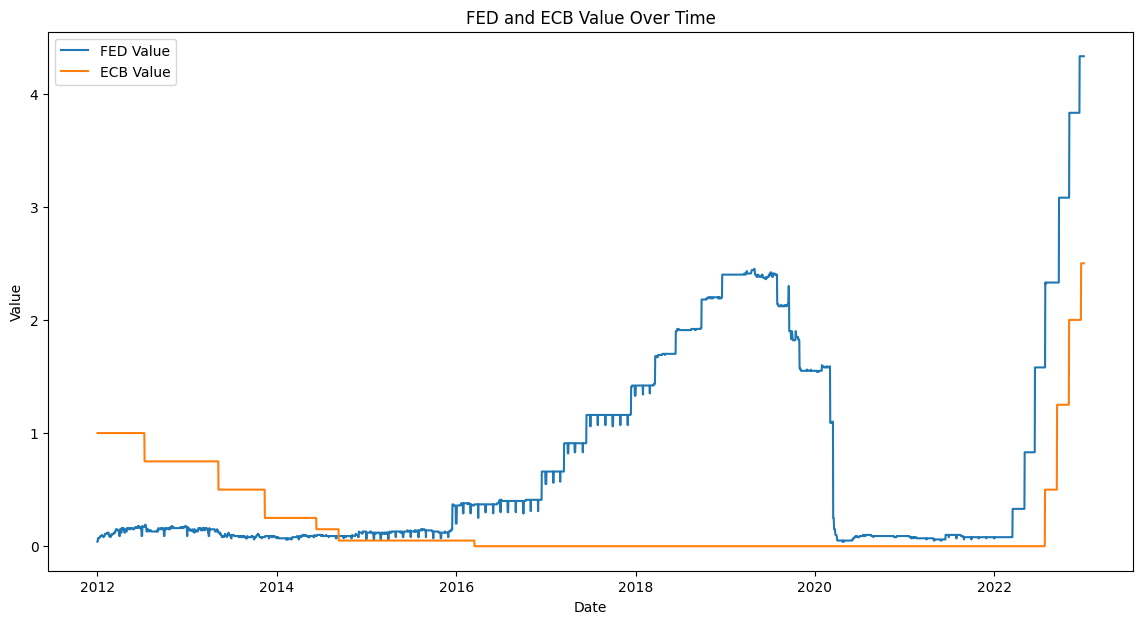

In [ ]:
#We are going to compare the decisions with different lags to see if the FED decisions influenced the BCE (and vice-versa)

import matplotlib.pyplot as plt

# Set the date as the index for both DataFrames for plotting
df_FED.set_index('Date', inplace=True)
df_ECB.set_index('Date', inplace=True)

# Plot the 'Value' column from both DataFrames
plt.figure(figsize=(14,7))
plt.plot(df_FED['Value'], label='FED Value')
plt.plot(df_ECB['Value'], label='ECB Value')

# Providing labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('FED and ECB Value Over Time')
plt.legend()
plt.show()



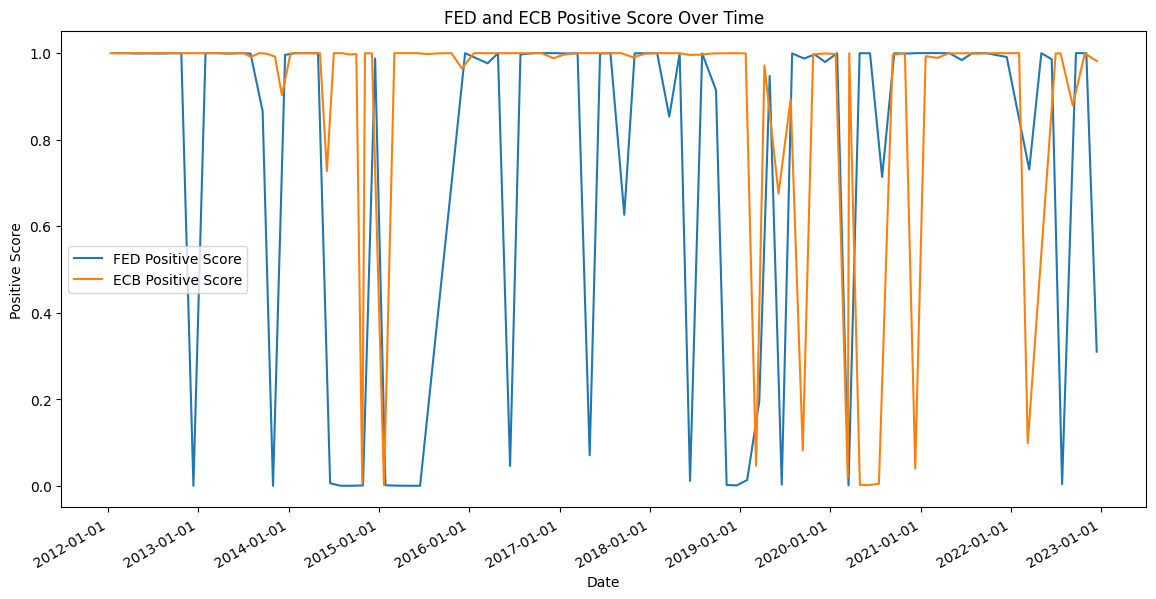

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

plt.figure(figsize=(14,7))

# Plot positive scores over time for each dataset
plt.plot(mergedFED_df['Date'], mergedFED_df['positive_score'], label='FED Positive Score')
plt.plot(mergedECB_df['Date'], mergedECB_df['positive_score'], label='ECB Positive Score')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel('Date')
plt.ylabel('Positive Score')
plt.title('FED and ECB Positive Score Over Time')
plt.legend()

# Rotate date labels
plt.gcf().autofmt_xdate()
plt.show()

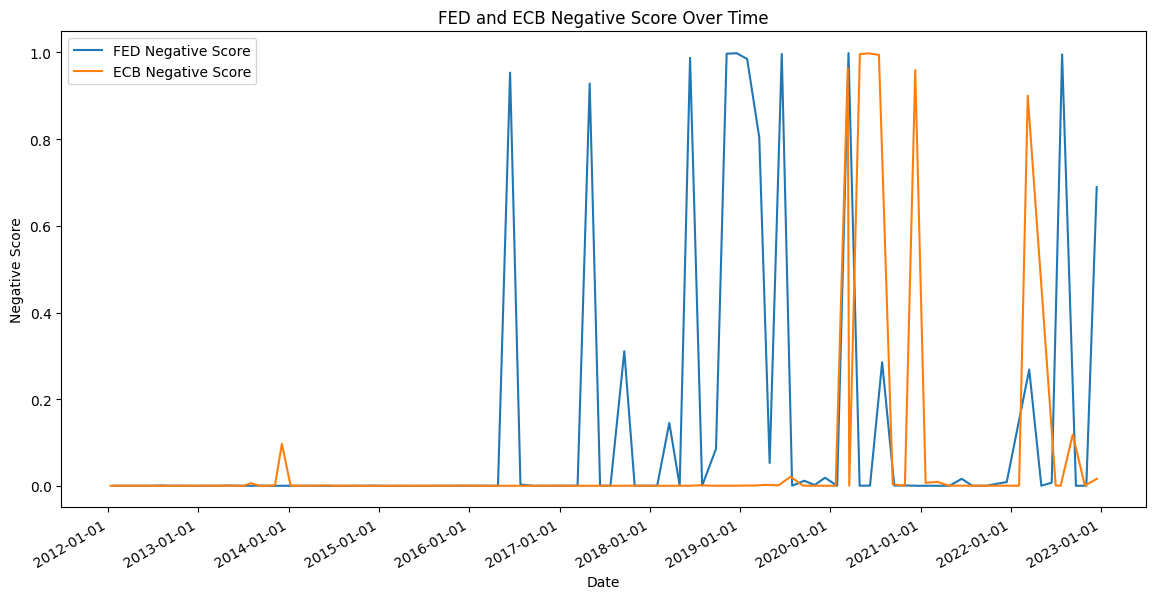

In [ ]:

plt.figure(figsize=(14,7))

# Plot negative scores over time for each dataset
plt.plot(mergedFED_df['Date'], mergedFED_df['negative_score'], label='FED Negative Score')
plt.plot(mergedECB_df['Date'], mergedECB_df['negative_score'], label='ECB Negative Score')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel('Date')
plt.ylabel('Negative Score')
plt.title('FED and ECB Negative Score Over Time')
plt.legend()

# Rotate date labels
plt.gcf().autofmt_xdate()
plt.show()

#Granger causality test

In [ ]:
# Using a Granger Causality test only on rate

import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
# Merge the datasets on the date column, ensuring they are aligned
combined_df = pd.merge(df_FED, df_ECB, on='Date')
print(combined_df)
# Conduct Granger causality test
# The maxlag parameter should be set based on your data's frequency and the economic intuition
gc_results = grangercausalitytests(combined_df[['Value_x', 'Value_y']], maxlag=4)
print(gc_results)

           Date  Value_x  Value_y
0    2012-01-01     0.04      1.0
1    2012-01-02     0.04      1.0
2    2012-01-03     0.07      1.0
3    2012-01-04     0.07      1.0
4    2012-01-05     0.07      1.0
...         ...      ...      ...
4014 2022-12-28     4.33      2.5
4015 2022-12-29     4.33      2.5
4016 2022-12-30     4.33      2.5
4017 2022-12-31     4.33      2.5
4018 2023-01-01     4.33      2.5

[4019 rows x 3 columns]

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.9568  , p=0.0016  , df_denom=4015, df_num=1
ssr based chi2 test:   chi2=9.9643  , p=0.0016  , df=1
likelihood ratio test: chi2=9.9519  , p=0.0016  , df=1
parameter F test:         F=9.9568  , p=0.0016  , df_denom=4015, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=197.9451, p=0.0000  , df_denom=4012, df_num=2
ssr based chi2 test:   chi2=396.3836, p=0.0000  , df=2
likelihood ratio test: chi2=378.0250, p=0.0000  , df=2
parameter F test:         F=197.9

All the p-values across different numbers of lags are well below the 0.05 threshold, indicating a strong predictive relationship. Specifically, the p-values are effectively zero at lags 2, 3, and 4, which strongly suggests that the Federal Reserve's interest rates Granger-cause the ECB's rates within the scope of this data.

This implies that past values of the Fed's rates are statistically significant predictors of the ECB's rates, which is in line with our hypothesis that the Fed influences the ECB. However, while Granger causality indicates predictability, it does not necessarily imply true causality in the economic sense.
 Since direct merging is not possible due to misaligned dates, focusing on individual time series analysis and then comparing patterns or using event study methodology could be more fruitful.

#VAR model


We will the interest rate values and inflation rates for each dataset separately to model how each central bank responds to changes in inflation and economic conditions over time.
For this, VAR models and their associated IRFs and FEVDs (Forecast Error Variance Decompositions) can be used to understand the dynamic relationship and impact within each dataset. The problem in our case is the fact tat we can't merge FED dataset with the ECB one (because speeches are not the same day).

*The FED analysis*

<ipython-input-9-991f69e54a13>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fed_data_analysis['Date'] = pd.to_datetime(fed_data_analysis['Date'])
<ipython-input-9-991f69e54a13>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fed_data_analysis.sort_values('Date', inplace=True)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


{'Value': False, 'Inflation_Rate': False, 'negative_score': True, 'neutral_score': False, 'positive_score': True}
{'Value': True, 'Inflation_Rate': True, 'negative_score': True, 'neutral_score': True, 'positive_score': True}
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Jan, 2024
Time:                     19:26:58
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -29.4161
Nobs:                     80.0000    HQIC:                  -29.9513
Log likelihood:           674.800    FPE:                6.87724e-14
AIC:                     -30.3094    Det(Omega_mle):     4.79040e-14
--------------------------------------------------------------------
Results for equation Value
                       coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------

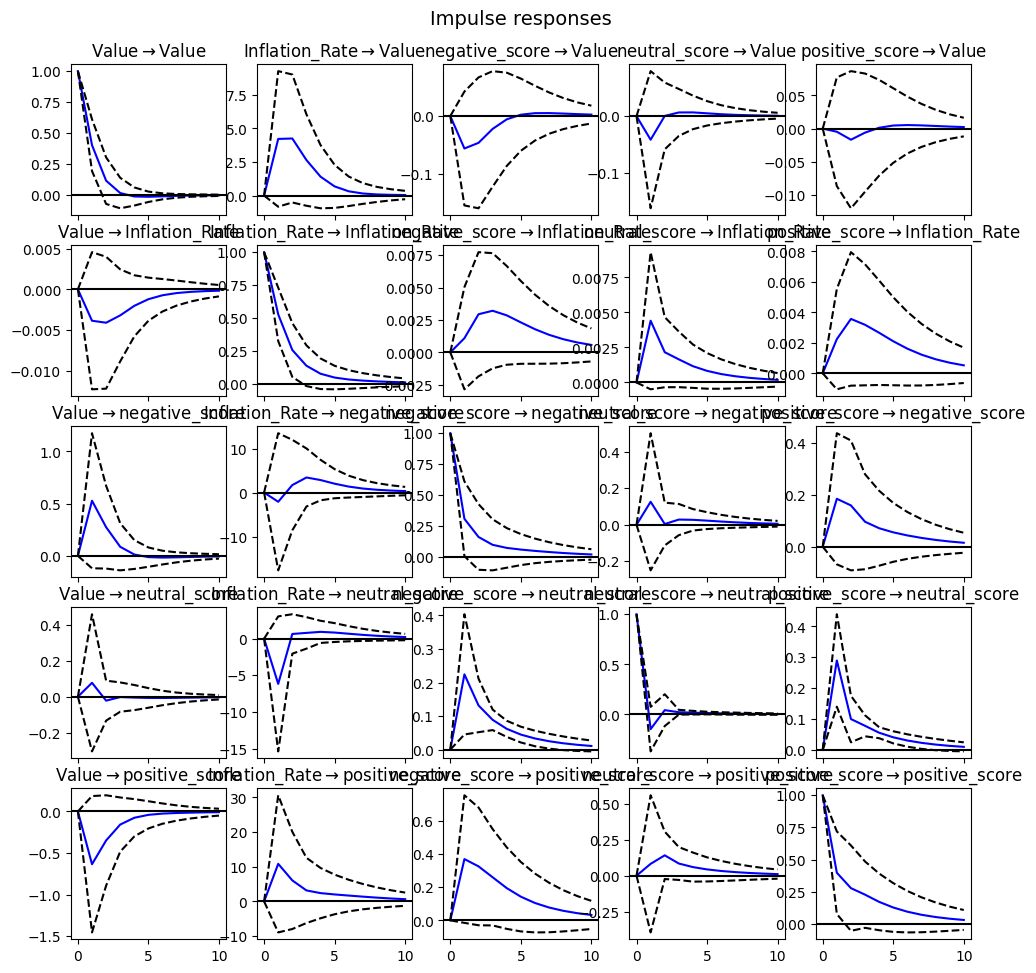

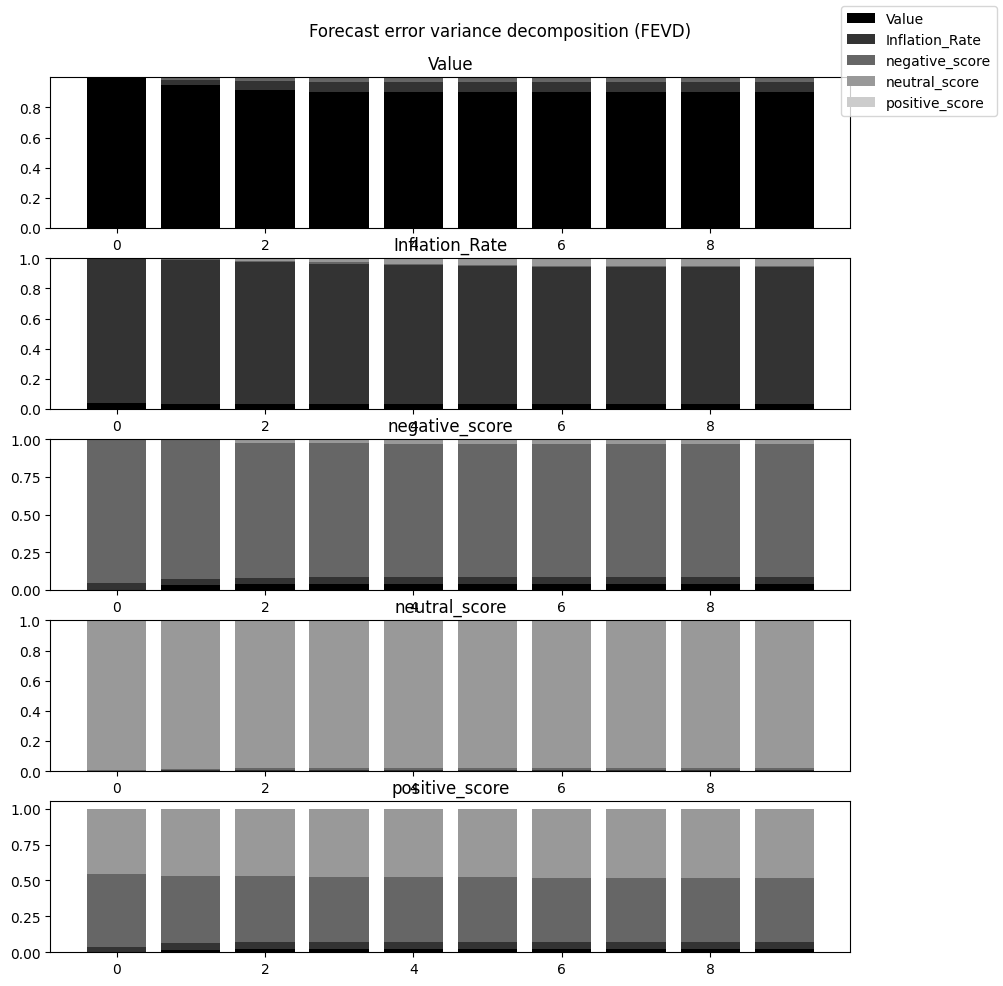

{'Value':      lb_stat  lb_pvalue
10  6.366058   0.783628, 'Inflation_Rate':      lb_stat  lb_pvalue
10  8.807836   0.550433, 'negative_score':      lb_stat  lb_pvalue
10  9.152557   0.517689, 'neutral_score':       lb_stat  lb_pvalue
10  37.057171   0.000055, 'positive_score':      lb_stat  lb_pvalue
10  7.824864   0.645939}


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

# Stationarity check function
def check_stationarity(series, cutoff=0.05):
    dftest = adfuller(series, autolag='AIC')
    p_value = dftest[1]
    return p_value < cutoff
fed_data = mergedFED_df.copy()

# We selet these features 'Date', 'Value', 'Inflation_Rate', 'negative_score', 'neutral_score', 'positive_score'
fed_columns_of_interest = ['Date', 'Value', 'Inflation_Rate', 'negative_score', 'neutral_score', 'positive_score']
fed_data_analysis = fed_data[fed_columns_of_interest]

# Convert 'Date' to datetime and set as index
fed_data_analysis['Date'] = pd.to_datetime(fed_data_analysis['Date'])
fed_data_analysis.set_index('Date', inplace=True)
fed_data_analysis.sort_values('Date', inplace=True)

fed_stationarity_results = {column: check_stationarity(fed_data_analysis[column]) for column in fed_data_analysis.columns if column != 'Date'}
print(fed_stationarity_results)
# Check for stationarity except for 'negative_score' and 'positive_score'
stationarity_to_check = ['Value', 'Inflation_Rate', 'neutral_score']
fed_stationarity_results = {column: check_stationarity(fed_data_analysis[column]) for column in stationarity_to_check}

# Log transform and difference for non-stationary series
fed_data_log_diff = fed_data_analysis.copy()
for column in stationarity_to_check:
    if not fed_stationarity_results[column]:  # If not stationary, then transform
        fed_data_log_diff[column] = np.log(fed_data_log_diff[column] + 1).diff()

fed_data_log_diff.dropna(inplace=True)

# Confirm that all my series are stationary
fed_stationarity_results = {column: check_stationarity(fed_data_log_diff[column]) for column in fed_data_log_diff.columns if column != 'Date'}
print(fed_stationarity_results)

# Fit VAR model
model = VAR(fed_data_log_diff)
optimal_lag = 1  # Replace with chosen lag based on AIC
var_model = model.fit(optimal_lag)
print(var_model.summary())
# Analyse IRF
irf = var_model.irf(10)  # 10 periods

# Create IRF plot
fig = irf.plot(orth=False)

# FEVD
fevd = var_model.fevd(10)  # Same as previously, 10 periods
fevd.plot()
plt.show()

fed_residuals = var_model.resid

# Perform the Ljung-Box test for each series of residuals
ljung_box_results_fed = {column: acorr_ljungbox(fed_residuals[column], lags=[10], return_df=True) for column in fed_residuals.columns}
print(ljung_box_results_fed)

ECB Analysis

<ipython-input-11-a198b22d9cac>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecb_data_analysis['Date'] = pd.to_datetime(ecb_data_analysis['Date'])
<ipython-input-11-a198b22d9cac>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecb_data_analysis.sort_values('Date', inplace=True)
<ipython-input-11-a198b22d9cac>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

{'Value': False, 'negative_score': True, 'neutral_score': True, 'positive_score': False, 'Inflation_Rate': False}
Value: Number of differences applied = 3
positive_score: Number of differences applied = 1
Inflation_Rate: Number of differences applied = 3
{'Value': True, 'negative_score': True, 'neutral_score': True, 'positive_score': True, 'Inflation_Rate': True}


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Jan, 2024
Time:                     19:30:47
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -42.6369
Nobs:                     98.0000    HQIC:                  -43.1082
Log likelihood:           1462.70    FPE:                1.37939e-19
AIC:                     -43.4282    Det(Omega_mle):     1.02289e-19
--------------------------------------------------------------------
Results for equation Value
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     0.002149         0.012517            0.172           0.864
L1.Value                 -0.564658         0.088494           -6.381           0.000
L1.negative_score        -0.000919         0

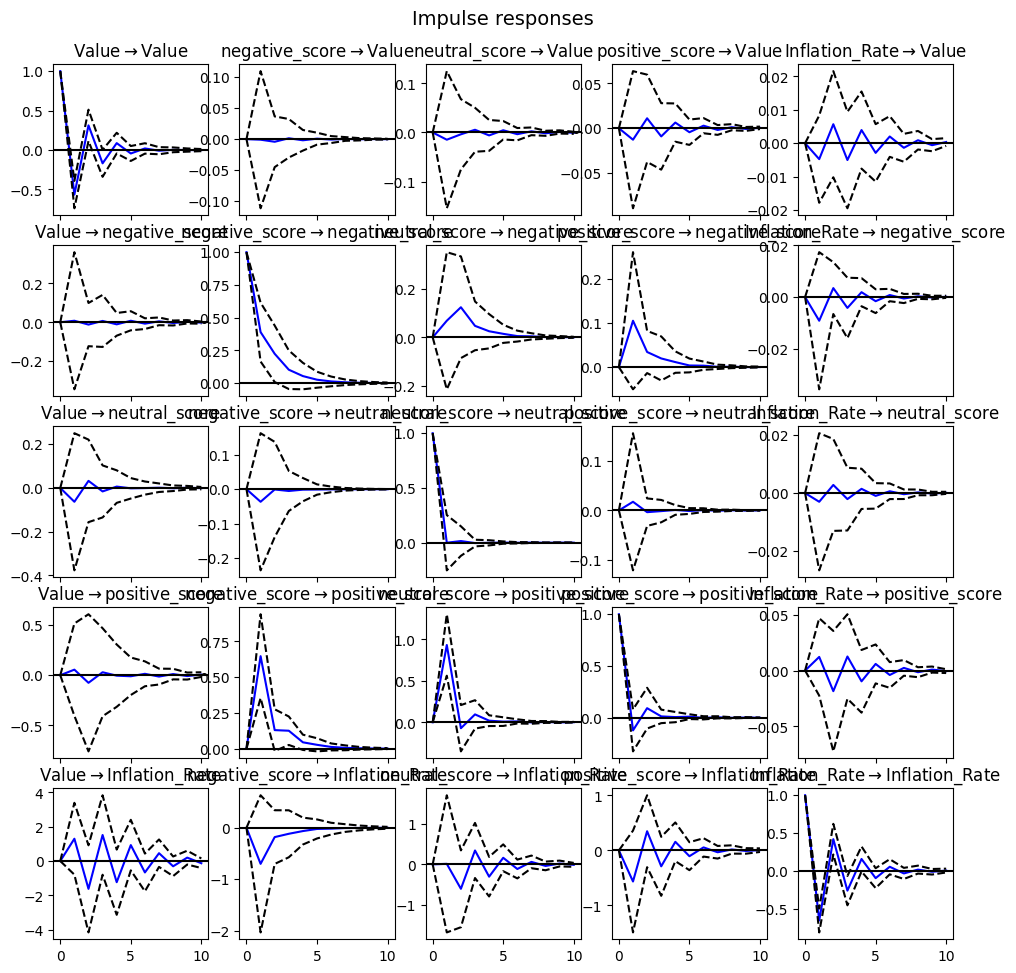

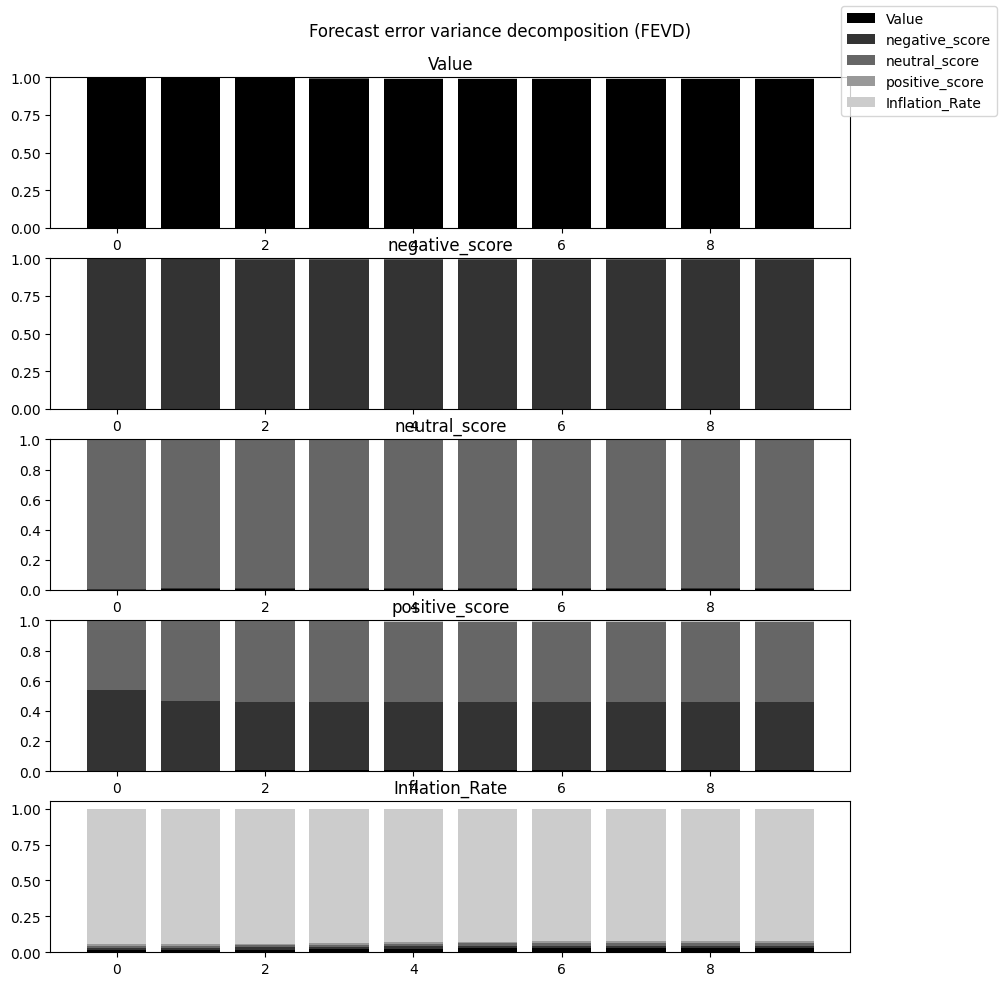

{'Value':      lb_stat  lb_pvalue
10  39.10067   0.000024, 'negative_score':       lb_stat  lb_pvalue
10  18.827618   0.042508, 'neutral_score':      lb_stat  lb_pvalue
10  11.37576   0.329002, 'positive_score':      lb_stat  lb_pvalue
10  20.10153   0.028307, 'Inflation_Rate':       lb_stat     lb_pvalue
10  55.323476  2.747713e-08}


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

# Stationarity check function
def check_stationarity(series, cutoff=0.05):
    dftest = adfuller(series, autolag='AIC')
    p_value = dftest[1]
    return p_value < cutoff

# Function to apply differencing iteratively until the series becomes stationary
def make_stationary(series, cutoff=0.05):
    series_diff = series.copy()
    num_diff = 0
    while True:
        if check_stationarity(series_diff, cutoff):
            break
        series_diff = series_diff.diff().dropna()
        num_diff += 1
        if num_diff > 10:  # Avoid excessive differencing
            break
    return series_diff, num_diff

# Assuming 'mergedECB_df' is already defined and loaded as a DataFrame
ecb_data = mergedECB_df.copy()

# Select features
ecb_columns_of_interest = ['Date', 'Value', 'negative_score', 'neutral_score', 'positive_score', 'Inflation_Rate']
ecb_data_analysis = ecb_data[ecb_columns_of_interest]

# Convert 'Date' to datetime and set as index
ecb_data_analysis['Date'] = pd.to_datetime(ecb_data_analysis['Date'])
ecb_data_analysis.set_index('Date', inplace=True)
ecb_data_analysis.sort_values('Date', inplace=True)

# Check for stationarity
ecb_stationarity_results = {column: check_stationarity(ecb_data_analysis[column]) for column in ecb_data_analysis.columns if column != 'Date'}
print(ecb_stationarity_results)

# Transform and check for stationarity
stationarity_to_check = ['Value', 'positive_score', 'Inflation_Rate']
for column in stationarity_to_check:
    transformed_series, num_diff = make_stationary(ecb_data_analysis[column])
    ecb_data_analysis[column] = transformed_series
    print(f"{column}: Number of differences applied = {num_diff}")

# Drop NaN values after differencing
ecb_data_analysis.dropna(inplace=True)

# Confirm stationarity
ecb_stationarity_results = {column: check_stationarity(ecb_data_analysis[column]) for column in ecb_data_analysis.columns if column != 'Date'}
print(ecb_stationarity_results)

# Fit VAR model
model = VAR(ecb_data_analysis)
optimal_lag_ecb = 1  # Replace with chosen lag based on AIC
ecb_var_model = model.fit(optimal_lag_ecb)

print(ecb_var_model.summary())

# Analyse IRF
irf = ecb_var_model.irf(10)  # 10 periods
fig = irf.plot(orth=False)

# Analyzing FEVD
fevd = ecb_var_model.fevd(10)
fevd.plot()
plt.show()

# Ljung-Box test on residuals
ecb_residuals = ecb_var_model.resid
ljung_box_results_ecb = {column: acorr_ljungbox(ecb_residuals[column], lags=[10], return_df=True) for column in ecb_residuals.columns}
print(ljung_box_results_ecb)